Testing out various models which use XGboost with the laligadfmod dataframe here.

In [105]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import BaggingClassifier as bg
from sklearn.model_selection import train_test_split
import pandas as pd 
import xgboost as xgb 
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
#from sklearn import accuracy
import random
from sklearn.neighbors import NeighborhoodComponentsAnalysis as nca 
 
random.seed()
rand = random.randint(1,100)



In [106]:
laligadfmod = pd.read_pickle('laligadfmod')

y=laligadfmod['outcome']
X=laligadfmod.loc[:, laligadfmod.columns!='outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.5, 
                                                    shuffle=True, stratify=y)

Computing weight for the weighted XGboost
weight = shots missed/ successful shots

In [107]:
laligadf = pd.read_pickle('laligadfmod')
count = 0
temp1 = laligadf.reset_index()
temp = temp1['outcome'].copy()
for i in range(len(temp)):
    if(temp[i]==1):
        count = count+1
goals = count
misses = len(temp)-goals
weight = misses/goals
print(weight)

6.4858569051580695


Weighted plain XGboost model

In [108]:
param_grid = [{'n_estimators': range(5,10)}]
                

#boost = xgb.XGBClassifier(
#        n_estimators = 10,
#        learning_rate = .01,
#        scale_pos_weight = weight,
#        booster = 'gb_linear', use_label_encoder = False)

boost = xgb.XGBClassifier(objective ='reg:squarederror', use_label_encoder=False, scale_pos_weight = weight, learning_rate = .0001)
gs = GridSearchCV(estimator=boost, param_grid=param_grid, cv=10, scoring='accuracy')


gs.fit(X_train,y_train)
print('Best Weighted XGboost Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Weighted XGboost Params: %s' % gs.best_params_)
print('Weighted XGboost Test Accuracy: %.2f%%' % (gs.best_estimator_.score(X_test,y_test)*100))

Best Weighted XGboost Accuracy: 91.64%
Best Weighted XGboost Params: {'n_estimators': 6}
Weighted XGboost Test Accuracy: 92.13%


Bagged weighted XGboost model using optimal parameters from last model

In [109]:

boost = xgb.XGBClassifier(n_estimators = 6, objective ='reg:squarederror', use_label_encoder=False, scale_pos_weight = weight, learning_rate = 0.0001)
pred = bg(base_estimator = boost,
        n_estimators = 500,
        random_state = rand
     ).fit(X_train,y_train)
pred.fit(X_train, y_train)

BaggingClassifier(base_estimator=XGBClassifier(base_score=None, booster=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               enable_categorical=False,
                                               gamma=None, gpu_id=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.0001,
                                               max_delta_step=None,
                                               max_depth=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                

In [110]:
print('Bagged Weighted XGBoost Training Accuracy: %.2f%%' % (pred.score(X_train, y_train)*100))
print('Bagged Weighted XGBoost Test Accuracy: %.2f%%' % (pred.score(X_test,y_test)*100))

Bagged Weighted XGBoost Training Accuracy: 93.15%
Bagged Weighted XGBoost Test Accuracy: 92.36%


In [111]:
import numpy as np
from mlxtend.evaluate import mcnemar_table

y_model_1 = gs.predict(X_test)
y_model_2 = pred.predict(X_test)


y_target = y_test

tb = mcnemar_table(y_target=y_target, 
                   y_model1=y_model_1, 
                   y_model2=y_model_2)

print(tb)


[[2061   12]
 [  17  160]]


Calculating chi2 and p values for weighted comparison of bagged and regular xgboost

In [112]:
from mlxtend.evaluate import mcnemar

chi2, p = mcnemar(ary=tb, corrected=True)
print('chi-squared:', chi2)
print('p-value:', p)

chi-squared: 0.5517241379310345
p-value: 0.4576140668763148


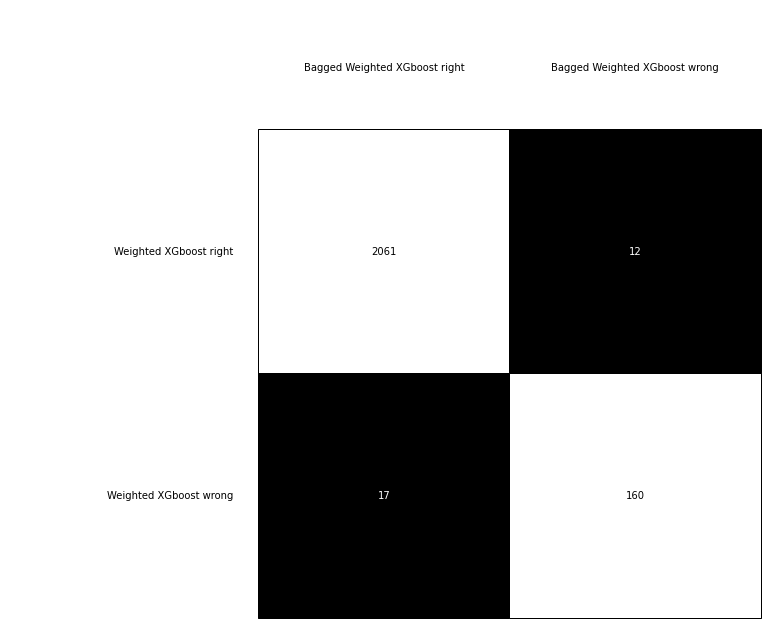

In [113]:
from mlxtend.plotting import checkerboard_plot
import matplotlib.pyplot as plt

brd = checkerboard_plot(tb,
                        figsize=(9, 9),
                        fmt='%d',
                        col_labels=['Bagged Weighted XGboost right', 'Bagged Weighted XGboost wrong'],
                        row_labels=['Weighted XGboost right', 'Weighted XGboost wrong'])
plt.show()


Unweighted Classifiers


Doing gridsearch with unweighted xgboost 

In [114]:
param_grid = [{'n_estimators': range(5,10)}]
                

boost_uw = xgb.XGBClassifier(objective ='reg:squarederror', use_label_encoder=False, learning_rate = .0001, weight_pos = 1)
gs_uw = GridSearchCV(estimator=boost, param_grid=param_grid, cv=10, scoring='accuracy')


gs_uw.fit(X_train,y_train)
print('Unweighted Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Unweighted Best Params: %s' % gs.best_params_)
print('Unweighted Test Accuracy: %.2f%%' % (gs.best_estimator_.score(X_test,y_test)*100))

Unweighted Best Accuracy: 91.64%
Unweighted Best Params: {'n_estimators': 6}
Unweighted Test Accuracy: 92.13%


Choosing 5 estimators as determined optimal by gridsearch

In [115]:

boost_uw = xgb.XGBClassifier(n_estimators = 5, objective ='reg:squarederror', use_label_encoder=False, scale_pos_weight = 1, learning_rate = 0.0001)
pred_uw = bg(base_estimator = boost_uw, n_estimators = 500, random_state = rand)
pred_uw.fit(X_train, y_train)

BaggingClassifier(base_estimator=XGBClassifier(base_score=None, booster=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               enable_categorical=False,
                                               gamma=None, gpu_id=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.0001,
                                               max_delta_step=None,
                                               max_depth=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                

In [116]:
import numpy as np
from mlxtend.evaluate import mcnemar_table

y_model_1_uw = gs_uw.predict(X_test)
y_model_2_uw = pred_uw.predict(X_test)


y_target_uw = y_test

tb_uw = mcnemar_table(y_target=y_target_uw, 
                   y_model1=y_model_1_uw, 
                   y_model2=y_model_2_uw)

print(tb_uw)


[[2015   58]
 [  77  100]]


Calculating chi2 and p values for weighted comparison of bagged and regular xgboost

In [117]:
from mlxtend.evaluate import mcnemar

chi2_uw, p_uw = mcnemar(ary=tb_uw, corrected=True)
print('chi-squared:', chi2_uw)
print('p-value:', p_uw)

chi-squared: 2.4
p-value: 0.12133525035848208


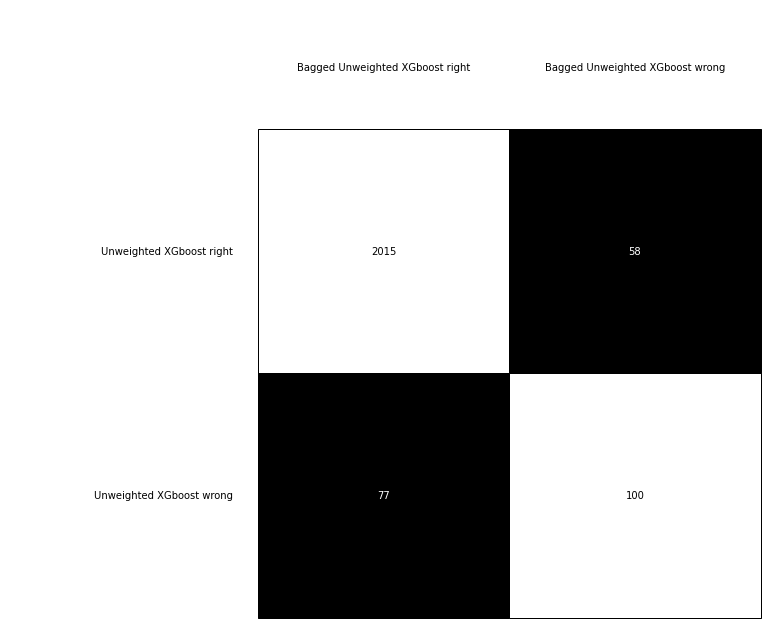

In [118]:
from mlxtend.plotting import checkerboard_plot
import matplotlib.pyplot as plt

brd = checkerboard_plot(tb_uw,
                        figsize=(9, 9),
                        fmt='%d',
                        col_labels=['Bagged Unweighted XGboost right', 'Bagged Unweighted XGboost wrong'],
                        row_labels=['Unweighted XGboost right', 'Unweighted XGboost wrong'])
#brd.title("Unweighted XGboost vs Bagged Unweighted XGboost")
plt.show()
